In [4]:
%matplotlib inline

In [5]:
# from __future__ import print_function, division, unicode_literals
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch
import os
from torch.utils.data import random_split
import torchvision
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from PIL import Image


Preparation before working

1.show the number of train data

In [6]:
def show_number():
    picture_frames = pd.read_csv('train.csv')
    labels = picture_frames.iloc[:,1]
    labels = labels.to_list()
    x = set(labels)
    y = []
    for a in x:
        y.append(labels.count(a))
    x = list(x)
    plt.figure(figsize=(5, 4))
    plt.bar(x, y, facecolor='#1f77b4', edgecolor='k')
    # plt.xticks(rotation=90)
    plt.tick_params(labelsize=15)
    plt.xlabel('class', fontsize=10)
    plt.ylabel('number of data', fontsize=10)

In [7]:
# use_cuda = True
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# device
# torch.cuda.device_count()
# train_dir = os.path.abspath("train")
# img_name = os.path.join(train_dir,"1.png")
# img_name

In [8]:
# picture_frames = pd.read_csv('train.csv')
# picture_name = picture_frames.iloc[:,0]
# label = picture_frames.iloc[:,1]
# picture_name = np.asarray(picture_name)
# label = np.asarray(label)

In [9]:
class CellPictureDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file=None, transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if csv_file is not None:
            self.data_frame = pd.read_csv(csv_file)
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            self.image = self.transform(image)
        if self.test is False:
            label = self.data_frame.iloc[idx, 1]
            # label = np.asarray(label)
            # self.label = torch.from_numpy(label).unsqueeze_(0)
            # sample = [self.image, self.label]
            return self.image, label
        else:
            return self.image

In [10]:
import collections
class MyConvNet(nn.Module):
    def __init__(self, l1=120):
        super().__init__()
        self.model = nn.Sequential(collections.OrderedDict([
            ('conv1', nn.Conv2d(3,32,5,stride=5)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32,16,5,stride=2)),
            ('relu2', nn.ReLU()),
            # Put in a linear layers ...
            ('flatten', nn.Flatten()),                                          
            ('fc1', nn.Linear(80*80,l1)),
            ('relu3', nn.ReLU()),
            ('fc3', nn.Linear(l1,4)),
        ]))

    def forward(self, x):
        x = self.model(x)
        return x


In [11]:
# model = MyConvNet()
# data = torch.ones(10,3,224,224)
# result = model(data)
# result.shape

In [12]:
# data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
# train_dataset = CellPictureDataset('train', csv_file='train.csv', transform=data_transform)
# test_dataset = CellPictureDataset('train',transform=data_transform, test=True)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

2.visualize a batch

In [13]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
train_dataset = CellPictureDataset('train', csv_file='train.csv', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

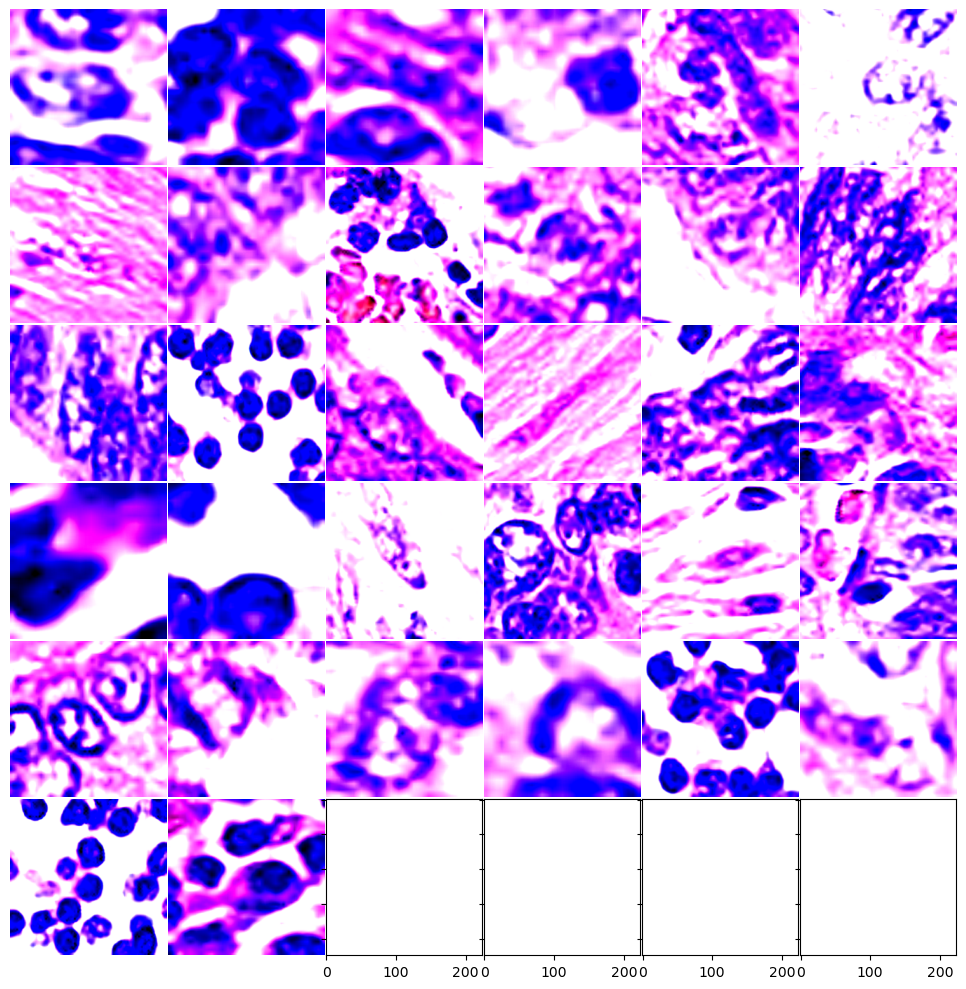

In [58]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_a_batch():
    images, labels = next(iter(train_loader))

    images = images.numpy()

    n=6
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # 类似绘制子图 subplot(111)
                    nrows_ncols=(n, n),  # 创建 n 行 m 列的 axes 网格
                    axes_pad=0.02,  # 网格间距
                    share_all=True
                    )

    # 遍历每张图像
    for ax, im in zip(grid, images):
        ax.imshow(im.transpose((1,2,0)))
        ax.axis('off')

    plt.tight_layout()
# plt.show()

In [10]:
# model = MyConvNet()
# loss_fn = nn.CrossEntropyLoss()
# learning_rate = 1e-2
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [11]:
# def training_loop():
#     total_train_step = 0
#     total_test_step = 0
#     epoch = 10
#     for i in range(epoch):
#         print("-------no.{} train begin".format(i+1))
#         for data in train_loader:
#             image, label = data
#             outputs = model(image)
#             loss = loss_fn(outputs, label)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_train_step = total_train_step + 1
#             if total_train_step % 100 == 0:
#                 print("trian times: {}, Loss: {}".format(total_train_step, loss.item()))
        


In [12]:
# training_loop()

In [13]:
# def load_data(train_dir="train/", test_dir = "test/"):
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

#     train_dataset = CellPictureDataset(train_dir, csv_file='train.csv', transform=transform)
#     test_dataset = CellPictureDataset(test_dir,transform=transform, test=True)

#     return train_dataset, test_dataset

3.Function of training in tune

In [14]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = MyConvNet(config["l1"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # trainset, testset = load_data(data_dir)
    csv_dir = "D://python_code//deep learning coursework//train.csv"
    # data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    train_dir = "D://python_code//deep learning coursework//train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=train_transform)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader =DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=0)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            # if i % 100 == 99:  # print every 2000 mini-batches
            #     print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
            #                                     running_loss / epoch_steps))
            #     running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
#     print("Finished Training")

In [15]:
# config = {
#         "l1": 120,
#         "lr": 1e-2,
#         "batch_size": 4,
#         "momentum": 0.9
#     }
# train_cifar(config=config)

4.code for calculate the accurary

In [16]:
def test_accuracy(net, device="cpu"):
    root_dir = "D://python_code//deep learning coursework//train"
    csv_dir = "D://python_code//deep learning coursework//train.csv"
    data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    trainset = CellPictureDataset(root_dir=root_dir, csv_file=csv_dir, transform=data_transform)
    testloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
    

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

5.Code for training the model usin tune

In [17]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    # train_dir = os.path.abspath("train")
    # load_data(train_dir)
    configs = {
        # "l1": tune.sample_from(lambda _: 2 ** np.random.randint(6, 10)),
        "l1": 256,
        "lr": tune.loguniform(5e-3, 1e-2),
        # "batch_size": tune.choice([16, 32]),
        "batch_size": 16,
        "momentum": tune.loguniform(6e-1, 8e-1)
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        train_cifar,
        resources_per_trial={"gpu": gpus_per_trial},
        config=configs,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = MyConvNet(best_trial.config["l1"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


# if __name__ == "__main__":
    # You can change the number of GPUs per trial here:

In [18]:
# if __name__ == "__main__":
#     main(num_samples=15, max_num_epochs=10, gpus_per_trial=1)
    # config = {
    #     "l1": 120,
    #     "l2": 84,
    #     "lr": 1e-2,
    #     "batch_size": 4,
    #     "momentum": 0.9
    # }
    # train_cifar(config=config)

Best trial config: {'l1': 256, 'lr': 0.008830556690188944, 'batch_size': 16, 'momentum': 0.6994160916279658}
Best trial final validation loss: 0.3116818554699421
Best trial final validation accuracy: 0.8888888888888888

Import the vgg16 model and do transfer learning

In [19]:
model_2 = torchvision.models.vgg16(pretrained=True)

d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Code for drawing the loss and accurary curves when training

In [30]:
def training_and_visualize(model, learning_rate, monmentum):
    epoch = 10

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=monmentum)

    csv_dir = "D://python_code//deep learning coursework//train.csv"
    data_transform = train_transform
    train_dir = "D://python_code//deep learning coursework//train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=data_transform)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader =DataLoader(
        train_subset,
        batch_size=int(16),
        shuffle=True,
        num_workers=0)
    valloader = DataLoader(
        val_subset,
        batch_size=int(16),
        shuffle=True,
        num_workers=0)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epoch):
        # train the model
        train_loss = 0.0
        train_acc = 0.0
        # total_train = 0
        # step_train = 0
        for i, data in enumerate(trainloader, 0):
            # ...
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            # total_train += labels.size(0)
            train_acc += (predicted == labels).sum().item() / len(labels)

        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # validate the model
        val_loss = 0.0
        val_acc = 0.0
        # total = 0
        # correct = 0
        val_steps = 0
        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                with torch.no_grad():
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()

                    loss = loss_fn(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    # val_loss += loss.item()
                    val_acc += (predicted == labels).sum().item() / len(labels)

        val_loss /= len(valloader)
        val_acc /= len(valloader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # plot the training and validation losses
    axs[0].plot(train_losses, label="Training Loss")
    axs[0].plot(val_losses, label="Validation Loss")
    axs[0].legend()
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")

    # plot the training and validation accuracies
    axs[1].plot(train_accs, label="Training Accuracy")
    axs[1].plot(val_accs, label="Validation Accuracy")
    axs[1].legend()
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")

C:\Users\Yifan Wu\AppData\Local\Temp\ipykernel_19308\2192906176.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


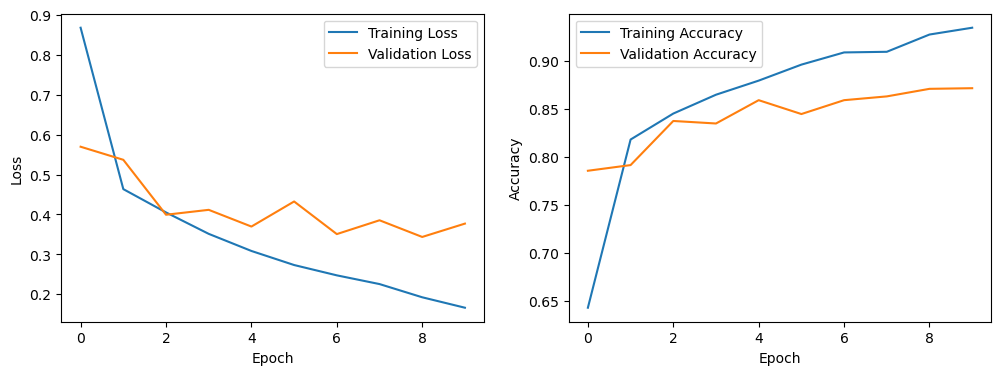

In [31]:
training_and_visualize(model = MyConvNet(l1=256), learning_rate=0.008830556690188944, monmentum=0.6994160916279658)

In [ ]:
# data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
# train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                      ])
# test_transform = transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(
#                                          mean=[0.485, 0.456, 0.406], 
#                                          std=[0.229, 0.224, 0.225])
#                                     ])
# train_dataset = CellPictureDataset('train', csv_file='train.csv', transform=data_transform)
# test_dataset = CellPictureDataset('train',transform=data_transform, test=True)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)
# model = MyConvNet()
# loss_fn = nn.CrossEntropyLoss()
# learning_rate = 0.008830556690188944
# momentum = 0.6994160916279658
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)


Code for create confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix

model = MyConvNet(l1=256)
images, labels = next(iter(train_loader))
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

confusion_matrix_model = confusion_matrix(labels.numpy(), predicted.numpy())


In [30]:

import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(4, 4))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('confusion matrix', fontsize=30)
    plt.xlabel('predicted', fontsize=25, c='r')
    plt.ylabel('real class', fontsize=25, c='r')
    plt.tick_params(labelsize=12) # 设置类别文字大小
    # plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    # plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    # plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像

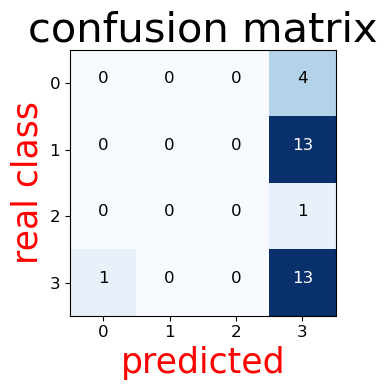

In [31]:
cnf_matrix_plotter(confusion_matrix_model, labels.numpy().tolist(),cmap='Blues')

Code for Occlusion

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def doing_occulsion(model, input_tensor, pred_id, rc_img_norm):
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (3, 8, 8), # 遮挡滑动移动步长
                                       target=pred_id, # 目标类别
                                       sliding_window_shapes=(3, 15, 15), # 遮挡滑块尺寸
                                       baselines=0) # 被遮挡滑块覆盖的像素值
    attributions_occ_norm = np.transpose(attributions_occ.detach().cpu().squeeze().numpy(), (1,2,0))
    viz.visualize_image_attr_multiple(attributions_occ_norm, # 224 224 3
                                  rc_img_norm,           # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=2)

Code for integrated gradients

In [ ]:
def doing_ig(model, input_tensor, pred_id, rc_img_norm):
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_id, n_steps=200)
    attributions_ig_norm = np.transpose(attributions_ig.detach().cpu().squeeze().numpy(), (1,2,0))
    plt.imshow(attributions_ig_norm[:, :, 0] * 100)

    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

# 可视化 IG 值
    viz.visualize_image_attr(attributions_ig_norm, # 224,224,3
                            rc_img_norm,          # 224,224,3
                            method='heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=1)
    
    noise_tunnel = NoiseTunnel(integrated_gradients)

    # 获得输入图像每个像素的 IG 值
    attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=18, nt_type='smoothgrad_sq', target=pred_id)

    # 转为 224 x 224 x 3的数据维度
    attributions_ig_nt_norm = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))

    # 设置配色方案
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                    [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

    viz.visualize_image_attr_multiple(attributions_ig_nt_norm, # 224 224 3
                                    rc_img_norm, # 224 224 3
                                    ["original_image", "heat_map"],
                                    ["all", "positive"],
                                    cmap=default_cmap,
                                    show_colorbar=True)